In [ ]:
print("Installing dependencies...")
!pip install -q transformers datasets sentencepiece sacrebleu torch evaluate accelerate peft bitsandbytes openpyxl pandas matplotlib seaborn
!pip install "datasets<4.0.0"

Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
import torch
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset, concatenate_datasets
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM,
    Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq,
    TrainingArguments, Trainer, DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, TaskType
import evaluate
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Setup complete!
PyTorch: 2.9.0+cu126
CUDA: True
GPU: Tesla T4


In [ ]:
#  DATA LOADING

def load_production_corpus(max_samples=50000):
    # Priority order: OPUS-100 > OPUS Books > Tatoeba > CCMatrix
    print("LOADING PRODUCTION EN-NL PARALLEL CORPUS")

    datasets_loaded = []

    # 1.  OPUS-100
    try:
        ds = load_dataset("Helsinki-NLP/opus-100", "en-nl", split="train")
        ds = ds.map(lambda x: {'en': x['translation']['en'], 'nl': x['translation']['nl']})
        ds = ds.remove_columns(['translation'])
        print(f"Loaded {len(ds):,} sentence pairs")
        datasets_loaded.append(ds)
    except Exception as e:
        print("Failed")

    # 2.  OPUS Books
    try:
        ds = load_dataset("opus_books", "en-nl", split="train")
        ds = ds.map(lambda x: {'en': x['translation']['en'], 'nl': x['translation']['nl']})
        ds = ds.remove_columns([c for c in ds.column_names if c not in ['en', 'nl']])
        print(f"Loaded {len(ds):,} sentence pairs")
        datasets_loaded.append(ds)
    except Exception as e:
        print("Failed")

    # 3. Tatoeba
    try:
        ds = load_dataset("Helsinki-NLP/tatoeba_mt", "eng-nld", split="train")
        ds = ds.map(lambda x: {'en': x['sourceString'], 'nl': x['targetString']})
        ds = ds.remove_columns(['sourceString', 'targetString'])
        print(f"Loaded {len(ds):,} sentence pairs")
        datasets_loaded.append(ds)
    except Exception as e:
        print("Failed")

    # 4.  CCMatrix
    try:
        ds = load_dataset("yhavinga/ccmatrix", "en-nl", split="train", streaming=True)
        #  first N sample
        samples = []
        for i, example in enumerate(ds):
            if i >= min(max_samples, 100000):
                break
            samples.append({'en': example['en'], 'nl': example['nl']})
        ds = Dataset.from_dict({'en': [s['en'] for s in samples], 'nl': [s['nl'] for s in samples]})
        print(f"Loaded {len(ds):,} sentence pairs")
        datasets_loaded.append(ds)
    except Exception as e:
        print(f"Failed")


    # Combine
    combined = concatenate_datasets(datasets_loaded) if len(datasets_loaded) > 1 else datasets_loaded[0]

    # Data Cleaning
    print("Filtering by length (5-150 words)...")
    def is_valid(ex):
        en_len = len(ex['en'].split())
        nl_len = len(ex['nl'].split())
        return 5 <= en_len <= 150 and 5 <= nl_len <= 150

    combined = combined.filter(is_valid)

    # Shuffle and sample
    combined = combined.shuffle(seed=42)
    if max_samples and len(combined) > max_samples:
        combined = combined.select(range(max_samples))



    # Show samples
    print("\nSample translations:")
    for i in range(min(3, len(combined))):
        print(f"\n[{i+1}]")
        print(f"  EN: {combined[i]['en'][:100]}")
        print(f"  NL: {combined[i]['nl'][:100]}")

    return combined

In [ ]:
def load_custom_dataset(file_path='/content/Dataset_Challenge_1.xlsx'):
    try:
        df = pd.read_excel(file_path)
        dataset = Dataset.from_pandas(df)
        dataset = dataset.rename_column('English Source', 'en')
        dataset = dataset.rename_column('Reference Translation', 'nl')
        print(f"\n{len(dataset)} examples")
        return dataset
    except FileNotFoundError:
        print("\nDataset_Challenge_1.xlsx not found!")
        return None

# Load all data
print("STEP 1: DATA LOADING")

train_data = load_production_corpus(max_samples=50000)
software_test = load_custom_dataset()

from datasets import load_dataset

print("Loading FLORES dev for general domain evaluation...")
try:
    flores_test = load_dataset(
        "facebook/flores",
        "eng_Latn-nld_Latn",
        split="dev"
    )
    # Pair configs expose generic 'sentence1'/'sentence2' fields
    flores_test = flores_test.rename_column("sentence_eng_Latn", "en")
    flores_test = flores_test.rename_column("sentence_nld_Latn", "nl")
    print(f"FLORES: {len(flores_test)} examples")
except Exception as e:
    flores_test = None
    print("FLORES not available:", repr(e))


STEP 1: DATA LOADING
LOADING PRODUCTION EN-NL PARALLEL CORPUS


README.md: 0.00B [00:00, ?B/s]

en-nl/test-00000-of-00001.parquet:   0%|          | 0.00/208k [00:00<?, ?B/s]

en-nl/train-00000-of-00001.parquet:   0%|          | 0.00/82.5M [00:00<?, ?B/s]

en-nl/validation-00000-of-00001.parquet:   0%|          | 0.00/198k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Loaded 1,000,000 sentence pairs


README.md: 0.00B [00:00, ?B/s]

en-nl/train-00000-of-00001.parquet:   0%|          | 0.00/6.44M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/38652 [00:00<?, ? examples/s]

Map:   0%|          | 0/38652 [00:00<?, ? examples/s]

Loaded 38,652 sentence pairs


README.md: 0.00B [00:00, ?B/s]

tatoeba_mt.py: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

The repository for Helsinki-NLP/tatoeba_mt contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Helsinki-NLP/tatoeba_mt.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


test/tatoeba-test.eng-nld.tsv:   0%|          | 0.00/937k [00:00<?, ?B/s]

dev/tatoeba-dev.eng-nld.tsv:   0%|          | 0.00/4.55M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/12695 [00:00<?, ? examples/s]

Failed


README.md: 0.00B [00:00, ?B/s]

ccmatrix.py: 0.00B [00:00, ?B/s]

The repository for yhavinga/ccmatrix contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/yhavinga/ccmatrix.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] n
Failed
Filtering by length (5-150 words)...


Filter:   0%|          | 0/1038652 [00:00<?, ? examples/s]


Sample translations:

[1]
  EN: His 20, mile marker 2- 4- 3.
  NL: Zijn 20, mile marker 2-4-3.

[2]
  EN: This job is really important to me right now.
  NL: Ik heb dit baantje ontzettend hard nodig.

[3]
  EN: Taken together, the revision of existing curricula and the development of new courses represent the 
  NL: De herziening van bestaande leerplannen en de ontwikkeling van nieuwe cursussen zijn samen de belang

84 examples
Loading FLORES dev for general domain evaluation...


README.md: 0.00B [00:00, ?B/s]

flores.py: 0.00B [00:00, ?B/s]

The repository for facebook/flores contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/flores.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating dev split: 0 examples [00:00, ? examples/s]

Generating devtest split: 0 examples [00:00, ? examples/s]

FLORES: 997 examples


In [ ]:
# ENCODER DECODER MODEL (mBART-50)

tokenizer_mbart = AutoTokenizer.from_pretrained(
    "facebook/mbart-large-50-many-to-many-mmt",
    src_lang="en_XX",
    tgt_lang="nl_XX"
)
model_mbart = AutoModelForSeq2SeqLM.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

def preprocess_mbart(examples):
    inputs = tokenizer_mbart(examples['en'], max_length=128, truncation=True, padding='max_length')
    with tokenizer_mbart.as_target_tokenizer():
        labels = tokenizer_mbart(examples['nl'], max_length=128, truncation=True, padding='max_length')
    inputs["labels"] = labels["input_ids"]
    return inputs

# Prepare data
print("\nPreprocessing training data...")
train_mbart = train_data.map(preprocess_mbart, batched=True, remove_columns=train_data.column_names)

# Training arguments
training_args_mbart = Seq2SeqTrainingArguments(
    output_dir="./mbart_finetuned",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    learning_rate=5e-5,
    warmup_steps=500,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    logging_steps=100,
    save_steps=1000,
    save_total_limit=2,
    predict_with_generate=True,
    report_to="none"
)

# Train
trainer_mbart = Seq2SeqTrainer(
    model=model_mbart,
    args=training_args_mbart,
    train_dataset=train_mbart,
    data_collator=DataCollatorForSeq2Seq(tokenizer_mbart, model=model_mbart),
    tokenizer=tokenizer_mbart
)

print("\nTraining mBART-50...")
trainer_mbart.train()
trainer_mbart.save_model("./mbart_finetuned")
print("\n mBART training complete!")

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]


Preprocessing training data...


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]


Training mBART-50...


Step,Training Loss
100,8.988500
200,2.840800
300,0.378000
400,0.367000
500,0.361700
600,0.354800
700,0.354900
800,0.381800
900,0.356400
1000,0.371600


KeyboardInterrupt: 

In [ ]:
# DECODER-ONLY MODEL (GPT-2 + LoRA)

print("STEP 3: TRAINING DECODER-ONLY MODEL (GPT-2 + LoRA)")

# Initialize
tokenizer_gpt2 = AutoTokenizer.from_pretrained("gpt2")
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token
model_gpt2 = AutoModelForCausalLM.from_pretrained("gpt2")
model_gpt2.config.pad_token_id = tokenizer_gpt2.pad_token_id

# Apply LoRA
print("\nApplying LoRA configuration...")
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)
model_gpt2 = get_peft_model(model_gpt2, lora_config)
model_gpt2.print_trainable_parameters()

def preprocess_gpt2(examples):
    prompts = [f"Translate to Dutch: {src}\n\nTranslation: {tgt}{tokenizer_gpt2.eos_token}"
               for src, tgt in zip(examples['en'], examples['nl'])]
    inputs = tokenizer_gpt2(prompts, max_length=256, truncation=True, padding='max_length')
    inputs["labels"] = inputs["input_ids"].copy()
    return inputs

# Prepare data
print("\nPreprocessing training data...")
train_gpt2 = train_data.map(preprocess_gpt2, batched=True, remove_columns=train_data.column_names)

# Training arguments
training_args_gpt2 = TrainingArguments(
    output_dir="./gpt2_lora_finetuned",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    learning_rate=2e-4,
    warmup_steps=500,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    logging_steps=100,
    save_steps=1000,
    save_total_limit=2,
    report_to="none"
)

# Train
trainer_gpt2 = Trainer(
    model=model_gpt2,
    args=training_args_gpt2,
    train_dataset=train_gpt2,
    data_collator=DataCollatorForLanguageModeling(tokenizer_gpt2, mlm=False)
)

print("\nTraining GPT-2 with LoRA...")
trainer_gpt2.train()
model_gpt2.save_pretrained("./gpt2_lora_finetuned")
print("\nGPT-2 training complete!")

STEP 3: TRAINING DECODER-ONLY MODEL (GPT-2 + LoRA)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


Applying LoRA configuration...
trainable params: 1,622,016 || all params: 126,061,824 || trainable%: 1.2867

Preprocessing training data...


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]


Training GPT-2 with LoRA...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,4.944300
200,4.342600
300,4.090400
400,4.019700
500,3.960200
600,3.838000
700,3.847600
800,3.732500
900,3.721000
1000,3.654200


KeyboardInterrupt: 

In [ ]:
# STEP 4: EVALUATION

bleu_metric = evaluate.load("sacrebleu")
chrf_metric = evaluate.load("chrf")
ter_metric = evaluate.load("ter")

def evaluate_mbart(test_data, name):
    print(f"\nEvaluating mBART on {name}...")
    preds, refs = [], []

    for ex in test_data:
        inputs = tokenizer_mbart(ex['en'], return_tensors="pt", max_length=128, truncation=True).to(model_mbart.device)
        with torch.no_grad():
            outputs = model_mbart.generate(**inputs, max_length=128, num_beams=5, early_stopping=True)
        pred = tokenizer_mbart.decode(outputs[0], skip_special_tokens=True)
        preds.append(pred.strip())
        refs.append([ex['nl'].strip()])

    bleu = bleu_metric.compute(predictions=preds, references=refs)
    chrf = chrf_metric.compute(predictions=preds, references=[r[0] for r in refs])
    ter = ter_metric.compute(predictions=preds, references=refs)

    print(f"  BLEU: {bleu['score']:.2f}")
    print(f"  chrF: {chrf['score']:.2f}")
    print(f"  TER:  {ter['score']:.2f}")

    return {
        'model': 'mBART-50', 'dataset': name,
        'bleu': bleu['score'], 'chrf': chrf['score'], 'ter': ter['score']
    }, preds

def evaluate_gpt2(test_data, name):
    print(f"\nEvaluating GPT-2+LoRA on {name}...")
    preds, refs = [], []

    for ex in test_data:
        prompt = f"Translate to Dutch: {ex['en']}\n\nTranslation:"
        inputs = tokenizer_gpt2(prompt, return_tensors="pt", max_length=256, truncation=True).to(model_gpt2.device)
        with torch.no_grad():
            outputs = model_gpt2.generate(
                **inputs, max_new_tokens=128, num_beams=5,
                pad_token_id=tokenizer_gpt2.pad_token_id,
                early_stopping=True
            )
        full_text = tokenizer_gpt2.decode(outputs[0], skip_special_tokens=True)
        pred = full_text.split("Translation:")[-1].strip() if "Translation:" in full_text else full_text
        preds.append(pred)
        refs.append([ex['nl'].strip()])

    bleu = bleu_metric.compute(predictions=preds, references=refs)
    chrf = chrf_metric.compute(predictions=preds, references=[r[0] for r in refs])
    ter = ter_metric.compute(predictions=preds, references=refs)

    print(f"  BLEU: {bleu['score']:.2f}")
    print(f"  chrF: {chrf['score']:.2f}")
    print(f"  TER:  {ter['score']:.2f}")

    return {
        'model': 'GPT-2+LoRA', 'dataset': name,
        'bleu': bleu['score'], 'chrf': chrf['score'], 'ter': ter['score']
    }, preds

STEP 4: EVALUATION


In [ ]:
# Run evaluations
results = []
all_preds = {}

if software_test:
    r1, p1 = evaluate_mbart(software_test, "Software Domain")
    r2, p2 = evaluate_gpt2(software_test, "Software Domain")
    results.extend([r1, r2])
    all_preds['mbart_sw'] = p1
    all_preds['gpt2_sw'] = p2


Evaluating mBART on Software Domain...
  BLEU: 19.26
  chrF: 44.00
  TER:  66.19

Evaluating GPT-2+LoRA on Software Domain...
  BLEU: 0.57
  chrF: 11.59
  TER:  304.70


In [12]:
if flores_test:
    flores_subset = flores_test.select(range(200))
    r3, p3 = evaluate_mbart(flores_subset, "General (FLORES-200)")
    r4, p4 = evaluate_gpt2(flores_subset, "General (FLORES-200)")
    results.extend([r3, r4])


Evaluating mBART on General (FLORES-200)...
  BLEU: 18.55
  chrF: 50.08
  TER:  65.43

Evaluating GPT-2+LoRA on General (FLORES-200)...
  BLEU: 1.50
  chrF: 16.90
  TER:  210.69


In [13]:
# RESULTS & VISUALIZATION
print("FINAL RESULTS")

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# Save results
df_results.to_excel('evaluation_results.xlsx', index=False)
print("\nResults saved to 'evaluation_results.xlsx'")

FINAL RESULTS
     model              dataset      bleu      chrf        ter
  mBART-50      Software Domain 19.262044 43.999324  66.189990
GPT-2+LoRA      Software Domain  0.570551 11.592592 304.698672
  mBART-50 General (FLORES-200) 18.552664 50.080291  65.427114
GPT-2+LoRA General (FLORES-200)  1.497064 16.896175 210.688483

Results saved to 'evaluation_results.xlsx'


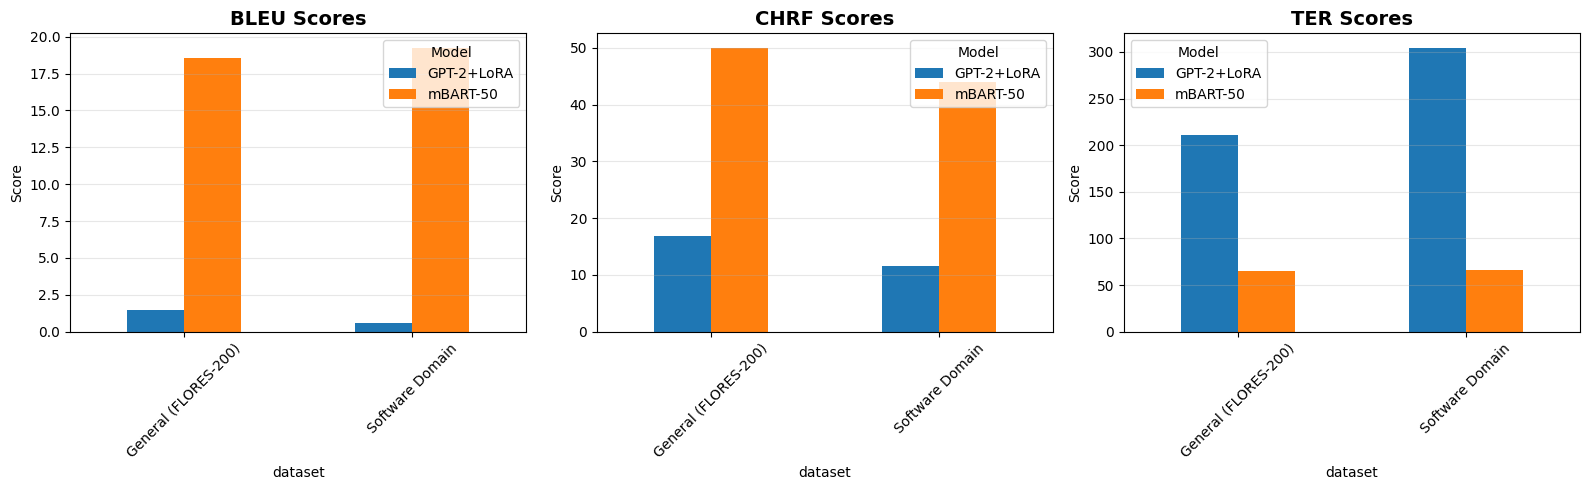


Visualization saved to 'comprehensive_results.png'


In [14]:
# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, metric in enumerate(['bleu', 'chrf', 'ter']):
    ax = axes[i]
    df_pivot = df_results.pivot(index='dataset', columns='model', values=metric)
    df_pivot.plot(kind='bar', ax=ax, rot=45)
    ax.set_title(f'{metric.upper()} Scores', fontsize=14, fontweight='bold')
    ax.set_ylabel('Score')
    ax.grid(axis='y', alpha=0.3)
    ax.legend(title='Model')

plt.tight_layout()
plt.savefig('comprehensive_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to 'comprehensive_results.png'")

In [15]:
# Save predictions
if software_test and all_preds:
    pred_df = pd.DataFrame({
        'English Source': [ex['en'] for ex in software_test],
        'Reference Dutch': [ex['nl'] for ex in software_test],
        'mBART Translation': all_preds.get('mbart_sw', [''] * len(software_test)),
        'GPT-2 Translation': all_preds.get('gpt2_sw', [''] * len(software_test))
    })
    pred_df.to_excel('software_domain_predictions.xlsx', index=False)
    print("Predictions saved to 'software_domain_predictions.xlsx'")

Predictions saved to 'software_domain_predictions.xlsx'
